In [1]:
## general imports
import os
import pandas as pd
import numpy as np
from importlib import reload

## visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## personal modules
import feature_extraction
import algorithms
import evaluate_performance
import augment_test as augment

In [2]:
os.getcwd()

'c:\\Users\\alessandro\\Documents\\UZH\\Thesis\\code\\test\\augmentation_techniques_test'

# Data Preparation

In [3]:
training = pd.read_csv("../datasets/training.csv", index_col=0, header=0)
testing = pd.read_csv("../datasets/testing.csv", index_col=0, header=0)

In [4]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4551 entries, 0 to 4550
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   GroupName   4551 non-null   object 
 1   Sex         4551 non-null   object 
 2   AgeDays     4551 non-null   int64  
 3   AgeYears    4551 non-null   float64
 4   RecDate     4551 non-null   object 
 5   SourceFile  4551 non-null   object 
 6   Code        4551 non-null   object 
 7   ID          4551 non-null   int64  
 8   CallFile    4551 non-null   object 
 9   CallTime    4551 non-null   object 
 10  CallType    4551 non-null   object 
 11  Path        4551 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 462.2+ KB


In [5]:
# class distribution
training.groupby(["Code"]).size()

Code
VBBF083    131
VBBF088    144
VBBF093     44
VBBM071    107
VBBM090    191
VRRF159     33
VRRF180    123
VRRM181    165
VRRM182    302
VRRM183    166
VUKF016    169
VUKF018    510
VUKM004    334
VUKM017    401
VVHM089    151
VWM132     285
VZUF009    217
VZUF014    703
VZUM011    203
VZUM016    172
dtype: int64

In [6]:
# exclude individuals with less than 100 calls
to_exclude = ["VBBF093", "VRRF159"]
training.drop(training[training["Code"].isin(to_exclude)].index, inplace=True)
testing.drop(testing[testing["Code"].isin(to_exclude)].index, inplace=True)

In [7]:
# class distribution
training.groupby(["Code"]).size()

Code
VBBF083    131
VBBF088    144
VBBM071    107
VBBM090    191
VRRF180    123
VRRM181    165
VRRM182    302
VRRM183    166
VUKF016    169
VUKF018    510
VUKM004    334
VUKM017    401
VVHM089    151
VWM132     285
VZUF009    217
VZUF014    703
VZUM011    203
VZUM016    172
dtype: int64

In [8]:
# random sample of obs. to balance classes
m = training.groupby(["Code"]).size().min()
training = training.groupby(["Code"]).sample(n=m, random_state=42)
training.reset_index(inplace=True, drop=True)

m = testing.groupby(["Code"]).size().min()
testing = testing.groupby(["Code"]).sample(n=m, random_state=42).reset_index()
testing.reset_index(inplace=True, drop=True)

training.groupby(["Code"]).size()

Code
VBBF083    107
VBBF088    107
VBBM071    107
VBBM090    107
VRRF180    107
VRRM181    107
VRRM182    107
VRRM183    107
VUKF016    107
VUKF018    107
VUKM004    107
VUKM017    107
VVHM089    107
VWM132     107
VZUF009    107
VZUF014    107
VZUM011    107
VZUM016    107
dtype: int64

## Load original audio signals

In [9]:
os.chdir("C:/Users/alessandro/Documents/UZH/Thesis")
sig_training, sr_training = feature_extraction.audio(training.Path.to_list())
sig_ts, sr_ts = feature_extraction.audio(testing.Path.to_list())

C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


In [10]:
# testing targets
y_ts, ind_ts = feature_extraction.get_targets(metadata_df=testing)

## Initialize augmenter and number of final calls

In [11]:
augmenter = augment.augment_audio(directory="audio/noise/")
N = 214 # 1:1 original:augmented

## Extracting test coefficients

In [12]:
coefs_ts, _ = feature_extraction.features(
    signals=sig_ts, sample_rates=sr_ts, n_subsamples=15, n_mels=40,
    n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs_ts.shape
X_ts = np.reshape(coefs_ts, newshape=(coefs_ts.shape[0], coefs_ts.shape[1]*coefs_ts.shape[2]))
X_ts.shape

(522, 675)

# Adding noise

In [13]:
tr = pd.DataFrame(columns=training.columns)

for i in training.Code.unique():
    print("INDIVIDUAL: ", i)

    # temporary dataframe
    tmp_df = training.loc[training["Code"] == i].copy(deep=True)

    # indeces of selected individual
    idx = training.loc[training["Code"] == i].index

    tmp_df = augmenter.SigAugment(
        signals=sig_training[idx], sample_rates=sr_training[idx], metadata=tmp_df,
        directory="code/test/augmentation_techniques_test/test_audio", N=N
    )

    tr = tr.append(tmp_df, ignore_index=True)

tr.groupby(["Code"]).size()

INDIVIDUAL:  VBBF083
INDIVIDUAL:  VBBF088
INDIVIDUAL:  VBBM071
INDIVIDUAL:  VBBM090
INDIVIDUAL:  VRRF180
INDIVIDUAL:  VRRM181
INDIVIDUAL:  VRRM182
INDIVIDUAL:  VRRM183
INDIVIDUAL:  VUKF016
INDIVIDUAL:  VUKF018
INDIVIDUAL:  VUKM004
INDIVIDUAL:  VUKM017
INDIVIDUAL:  VVHM089
INDIVIDUAL:  VWM132
INDIVIDUAL:  VZUF009
INDIVIDUAL:  VZUF014
INDIVIDUAL:  VZUM011
INDIVIDUAL:  VZUM016


Code
VBBF083    214
VBBF088    214
VBBM071    214
VBBM090    214
VRRF180    214
VRRM181    214
VRRM182    214
VRRM183    214
VUKF016    214
VUKF018    214
VUKM004    214
VUKM017    214
VVHM089    214
VWM132     214
VZUF009    214
VZUF014    214
VZUM011    214
VZUM016    214
dtype: int64

## Extracting training coefficients

In [14]:
# extract MFCCs
sig_tr, sr_tr = feature_extraction.audio(tr.Path.to_list())
coefs, _ = feature_extraction.features(
    signals=sig_tr, sample_rates=sr_tr, n_subsamples=15, n_mels=40,
    n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs.shape

(3852, 15, 45)

In [15]:
# training targets
y_tr, _ = feature_extraction.get_targets(metadata_df=tr)

In [16]:
# flattening array
X = np.reshape(coefs, newshape=(coefs.shape[0], coefs.shape[1]*coefs.shape[2]))
X.shape

(3852, 675)

## Classification

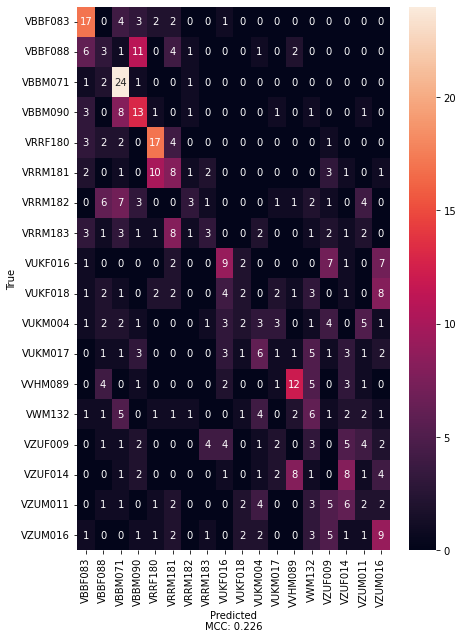

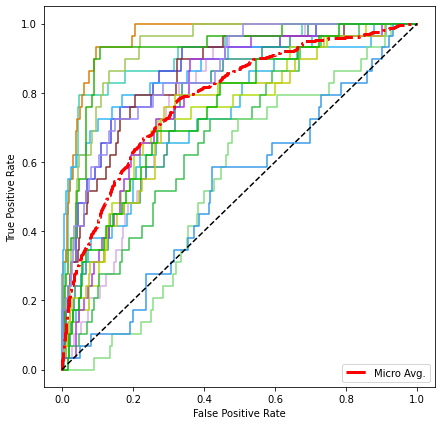

AUC score: 0.788


In [17]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y_tr)
pred_b, prob_b = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=ind_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=feature_extraction.one_hot(y_ts),
    y_score=prob_b, n_classes=len(ind_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

# Shifting signal

In [18]:
tr = pd.DataFrame(columns=training.columns)

for i in training.Code.unique():
    print("INDIVIDUAL: ", i)

    # temporary dataframe
    tmp_df = training.loc[training["Code"] == i].copy(deep=True)

    # indeces of selected individual
    idx = training.loc[training["Code"] == i].index

    tmp_df = augmenter.ShiftAugment(
        signals=sig_training[idx], sample_rates=sr_training[idx], metadata=tmp_df,
        directory="code/test/augmentation_techniques_test/test_audio", N=N
    )

    tr = tr.append(tmp_df, ignore_index=True)

tr.groupby(["Code"]).size()

INDIVIDUAL:  VBBF083
INDIVIDUAL:  VBBF088
INDIVIDUAL:  VBBM071
INDIVIDUAL:  VBBM090
INDIVIDUAL:  VRRF180
INDIVIDUAL:  VRRM181
INDIVIDUAL:  VRRM182
INDIVIDUAL:  VRRM183
INDIVIDUAL:  VUKF016
INDIVIDUAL:  VUKF018
INDIVIDUAL:  VUKM004
INDIVIDUAL:  VUKM017
INDIVIDUAL:  VVHM089
INDIVIDUAL:  VWM132
INDIVIDUAL:  VZUF009
INDIVIDUAL:  VZUF014
INDIVIDUAL:  VZUM011
INDIVIDUAL:  VZUM016


Code
VBBF083    214
VBBF088    214
VBBM071    214
VBBM090    214
VRRF180    214
VRRM181    214
VRRM182    214
VRRM183    214
VUKF016    214
VUKF018    214
VUKM004    214
VUKM017    214
VVHM089    214
VWM132     214
VZUF009    214
VZUF014    214
VZUM011    214
VZUM016    214
dtype: int64

## Extracting training coefficients

In [19]:
# extract MFCCs
sig_tr, sr_tr = feature_extraction.audio(tr.Path.to_list())
coefs, _ = feature_extraction.features(
    signals=sig_tr, sample_rates=sr_tr, n_subsamples=15, n_mels=40,
    n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs.shape

C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


(3852, 15, 45)

In [20]:
# training targets
y_tr, _ = feature_extraction.get_targets(metadata_df=tr)

In [21]:
# flattening array
X = np.reshape(coefs, newshape=(coefs.shape[0], coefs.shape[1]*coefs.shape[2]))
X.shape

(3852, 675)

## Classification

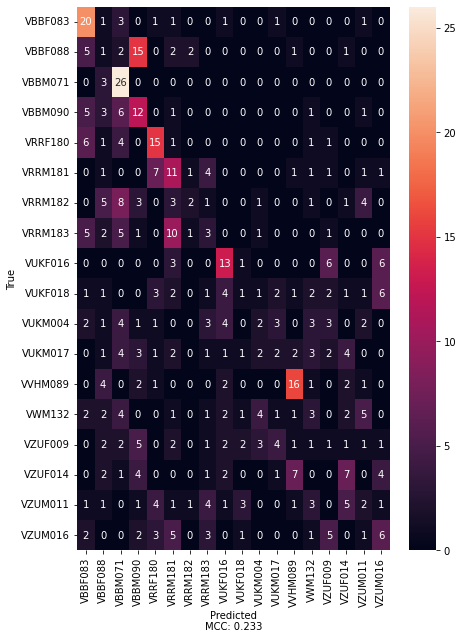

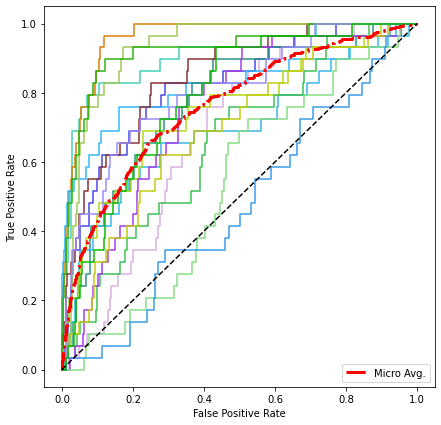

AUC score: 0.765


In [22]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y_tr)
pred_b, prob_b = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=ind_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=feature_extraction.one_hot(y_ts),
    y_score=prob_b, n_classes=len(ind_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

# Pitch Augmentation (librosa)

In [23]:
reload(augment)
augmenter = augment.augment_audio("audio/noise/")

In [24]:
tr = pd.DataFrame(columns=training.columns)

for i in training.Code.unique():
    print("INDIVIDUAL: ", i)

    # temporary dataframe
    tmp_df = training.loc[training["Code"] == i].copy(deep=True)

    # indeces of selected individual
    idx = training.loc[training["Code"] == i].index

    tmp_df = augmenter.PitchAugmentLibr(
        min_shift_Hz=25, max_shift_Hz=75,
        signals=sig_training[idx], sample_rates=sr_training[idx], metadata=tmp_df,
        directory="code/test/augmentation_techniques_test/test_audio", N=N
    )

    tr = tr.append(tmp_df, ignore_index=True)

tr.groupby(["Code"]).size()

INDIVIDUAL:  VBBF083
INDIVIDUAL:  VBBF088
INDIVIDUAL:  VBBM071
INDIVIDUAL:  VBBM090
INDIVIDUAL:  VRRF180
INDIVIDUAL:  VRRM181
INDIVIDUAL:  VRRM182
INDIVIDUAL:  VRRM183
INDIVIDUAL:  VUKF016
INDIVIDUAL:  VUKF018
INDIVIDUAL:  VUKM004
INDIVIDUAL:  VUKM017
INDIVIDUAL:  VVHM089
INDIVIDUAL:  VWM132
INDIVIDUAL:  VZUF009
INDIVIDUAL:  VZUF014
INDIVIDUAL:  VZUM011
INDIVIDUAL:  VZUM016


Code
VBBF083    214
VBBF088    214
VBBM071    214
VBBM090    214
VRRF180    214
VRRM181    214
VRRM182    214
VRRM183    214
VUKF016    214
VUKF018    214
VUKM004    214
VUKM017    214
VVHM089    214
VWM132     214
VZUF009    214
VZUF014    214
VZUM011    214
VZUM016    214
dtype: int64

## Extracting training coefficients

In [25]:
# extract MFCCs
sig_tr, sr_tr = feature_extraction.audio(tr.Path.to_list())
coefs, _ = feature_extraction.features(
    signals=sig_tr, sample_rates=sr_tr, n_subsamples=15, n_mels=40,
    n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs.shape

C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


(3852, 15, 45)

In [26]:
# training targets
y_tr, _ = feature_extraction.get_targets(metadata_df=tr)

In [27]:
# flattening array
X = np.reshape(coefs, newshape=(coefs.shape[0], coefs.shape[1]*coefs.shape[2]))
X.shape

(3852, 675)

## Classification

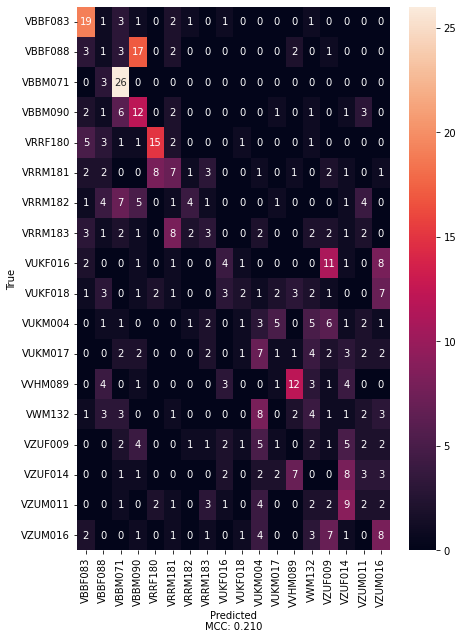

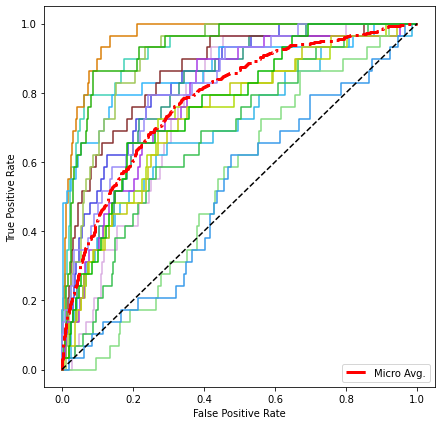

AUC score: 0.784


In [28]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y_tr)
pred_b, prob_b = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=ind_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=feature_extraction.one_hot(y_ts),
    y_score=prob_b, n_classes=len(ind_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

# Pitch shifting (numpy)

In [29]:
tr = pd.DataFrame(columns=training.columns)

for i in training.Code.unique():
    print("INDIVIDUAL: ", i)

    # temporary dataframe
    tmp_df = training.loc[training["Code"] == i].copy(deep=True)

    # indeces of selected individual
    idx = training.loc[training["Code"] == i].index

    tmp_df = augmenter.PitchAugmentNp(
        min_shift_Hz=25, max_shift_Hz=75,
        signals=sig_training[idx], sample_rates=sr_training[idx], metadata=tmp_df,
        directory="code/test/augmentation_techniques_test/test_audio", N=N
    )

    tr = tr.append(tmp_df, ignore_index=True)

tr.groupby(["Code"]).size()

INDIVIDUAL:  VBBF083
INDIVIDUAL:  VBBF088
INDIVIDUAL:  VBBM071
INDIVIDUAL:  VBBM090
INDIVIDUAL:  VRRF180
INDIVIDUAL:  VRRM181
INDIVIDUAL:  VRRM182
INDIVIDUAL:  VRRM183
INDIVIDUAL:  VUKF016
INDIVIDUAL:  VUKF018
INDIVIDUAL:  VUKM004
INDIVIDUAL:  VUKM017
INDIVIDUAL:  VVHM089
INDIVIDUAL:  VWM132
INDIVIDUAL:  VZUF009
INDIVIDUAL:  VZUF014
INDIVIDUAL:  VZUM011
INDIVIDUAL:  VZUM016


Code
VBBF083    214
VBBF088    214
VBBM071    214
VBBM090    214
VRRF180    214
VRRM181    214
VRRM182    214
VRRM183    214
VUKF016    214
VUKF018    214
VUKM004    214
VUKM017    214
VVHM089    214
VWM132     214
VZUF009    214
VZUF014    214
VZUM011    214
VZUM016    214
dtype: int64

## Extracting training coefficients

In [30]:
# extract MFCCs
sig_tr, sr_tr = feature_extraction.audio(tr.Path.to_list())
coefs, _ = feature_extraction.features(
    signals=sig_tr, sample_rates=sr_tr, n_subsamples=15, n_mels=40,
    n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs.shape

C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


(3852, 15, 45)

In [31]:
# training targets
y_tr, _ = feature_extraction.get_targets(metadata_df=tr)

In [32]:
# flattening array
X = np.reshape(coefs, newshape=(coefs.shape[0], coefs.shape[1]*coefs.shape[2]))
X.shape

(3852, 675)

## Classification

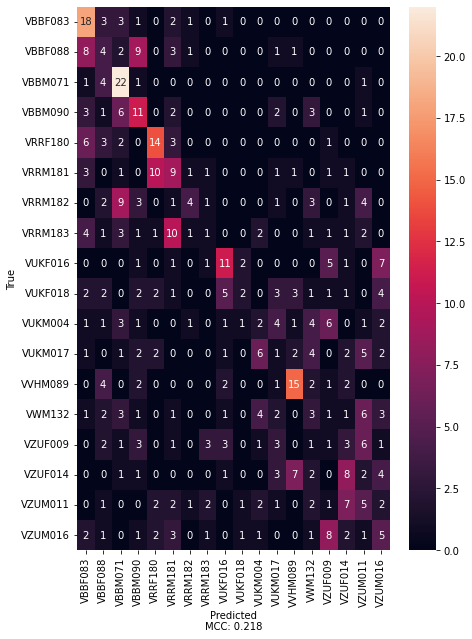

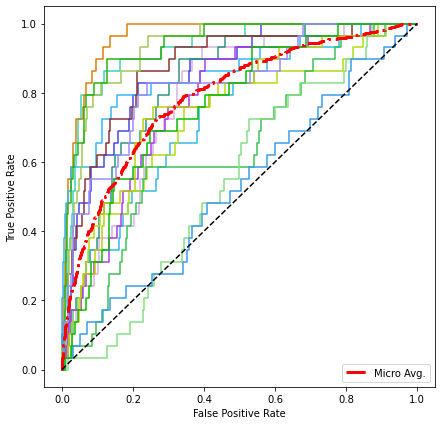

AUC score: 0.791


In [33]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y_tr)
pred_b, prob_b = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=ind_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=feature_extraction.one_hot(y_ts),
    y_score=prob_b, n_classes=len(ind_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

# Harmonic Distortion

In [34]:
tr = pd.DataFrame(columns=training.columns)

for i in training.Code.unique():
    print("INDIVIDUAL: ", i)

    # temporary dataframe
    tmp_df = training.loc[training["Code"] == i].copy(deep=True)

    # indeces of selected individual
    idx = training.loc[training["Code"] == i].index

    tmp_df = augmenter.HarmAugment(
        signals=sig_training[idx], sample_rates=sr_training[idx], metadata=tmp_df,
        directory="code/test/augmentation_techniques_test/test_audio", N=N
    )

    tr = tr.append(tmp_df, ignore_index=True)

tr.groupby(["Code"]).size()

INDIVIDUAL:  VBBF083
INDIVIDUAL:  VBBF088
INDIVIDUAL:  VBBM071
INDIVIDUAL:  VBBM090
INDIVIDUAL:  VRRF180
INDIVIDUAL:  VRRM181
INDIVIDUAL:  VRRM182
INDIVIDUAL:  VRRM183
INDIVIDUAL:  VUKF016
INDIVIDUAL:  VUKF018
INDIVIDUAL:  VUKM004
INDIVIDUAL:  VUKM017
INDIVIDUAL:  VVHM089
INDIVIDUAL:  VWM132
INDIVIDUAL:  VZUF009
INDIVIDUAL:  VZUF014
INDIVIDUAL:  VZUM011
INDIVIDUAL:  VZUM016


Code
VBBF083    214
VBBF088    214
VBBM071    214
VBBM090    214
VRRF180    214
VRRM181    214
VRRM182    214
VRRM183    214
VUKF016    214
VUKF018    214
VUKM004    214
VUKM017    214
VVHM089    214
VWM132     214
VZUF009    214
VZUF014    214
VZUM011    214
VZUM016    214
dtype: int64

## Extracting training coefficients

In [35]:
# extract MFCCs
sig_tr, sr_tr = feature_extraction.audio(tr.Path.to_list())
coefs, _ = feature_extraction.features(
    signals=sig_tr, sample_rates=sr_tr, n_subsamples=15, n_mels=40,
    n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs.shape

C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


(3852, 15, 45)

In [36]:
# training targets
y_tr, _ = feature_extraction.get_targets(metadata_df=tr)

In [37]:
# flattening array
X = np.reshape(coefs, newshape=(coefs.shape[0], coefs.shape[1]*coefs.shape[2]))
X.shape

(3852, 675)

## Classification

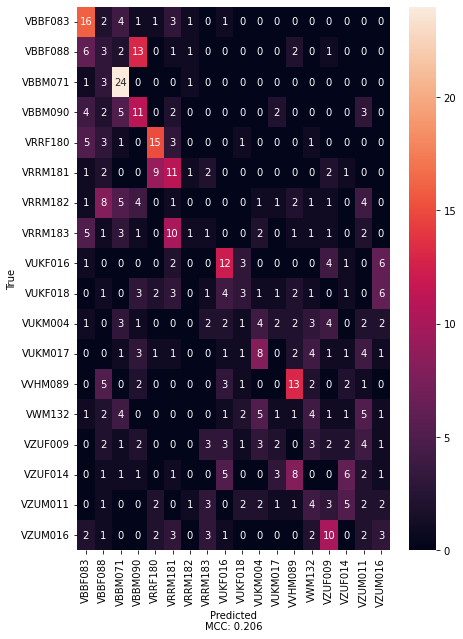

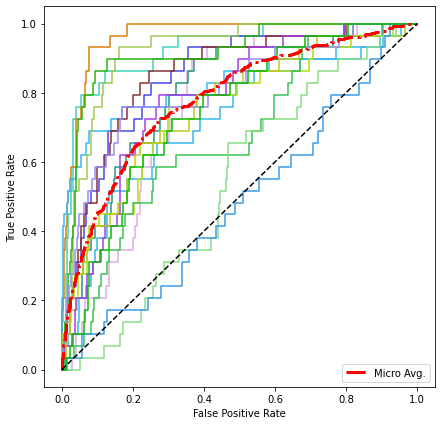

AUC score: 0.782


In [38]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y_tr)
pred_b, prob_b = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=ind_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=feature_extraction.one_hot(y_ts),
    y_score=prob_b, n_classes=len(ind_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

# Shift F0

In [79]:
tr = pd.DataFrame(columns=training.columns)

for i in training.Code.unique():
    print("INDIVIDUAL: ", i)

    # temporary dataframe
    tmp_df = training.loc[training["Code"] == i].copy(deep=True)

    # indeces of selected individual
    idx = training.loc[training["Code"] == i].index

    tmp_df = augmenter.shift_f0(
        min_shift_Hz=25, max_shift_Hz=75,
        signals=sig_training[idx], sample_rates=sr_training[idx], metadata=tmp_df,
        directory="code/test/augmentation_techniques_test/test_audio", N=N
    )

    tr = tr.append(tmp_df, ignore_index=True)

tr.groupby(["Code"]).size()

INDIVIDUAL:  VBBF083
INDIVIDUAL:  VBBF088
INDIVIDUAL:  VBBM071
INDIVIDUAL:  VBBM090
INDIVIDUAL:  VRRF180
INDIVIDUAL:  VRRM181
INDIVIDUAL:  VRRM182
INDIVIDUAL:  VRRM183
INDIVIDUAL:  VUKF016
INDIVIDUAL:  VUKF018
INDIVIDUAL:  VUKM004
INDIVIDUAL:  VUKM017
INDIVIDUAL:  VVHM089
INDIVIDUAL:  VWM132
INDIVIDUAL:  VZUF009
INDIVIDUAL:  VZUF014
INDIVIDUAL:  VZUM011
INDIVIDUAL:  VZUM016


Code
VBBF083    214
VBBF088    214
VBBM071    214
VBBM090    214
VRRF180    214
VRRM181    214
VRRM182    214
VRRM183    214
VUKF016    214
VUKF018    214
VUKM004    214
VUKM017    214
VVHM089    214
VWM132     214
VZUF009    214
VZUF014    214
VZUM011    214
VZUM016    214
dtype: int64

## Extracting training coefficients

In [80]:
# extract MFCCs
sig_tr, sr_tr = feature_extraction.audio(tr.Path.to_list())
coefs, _ = feature_extraction.features(
    signals=sig_tr, sample_rates=sr_tr, n_subsamples=15, n_mels=40,
    n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs.shape

C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


(3852, 15, 45)

In [81]:
# training targets
y_tr, _ = feature_extraction.get_targets(metadata_df=tr)

In [82]:
# flattening array
X = np.reshape(coefs, newshape=(coefs.shape[0], coefs.shape[1]*coefs.shape[2]))
X.shape

(3852, 675)

## Classification

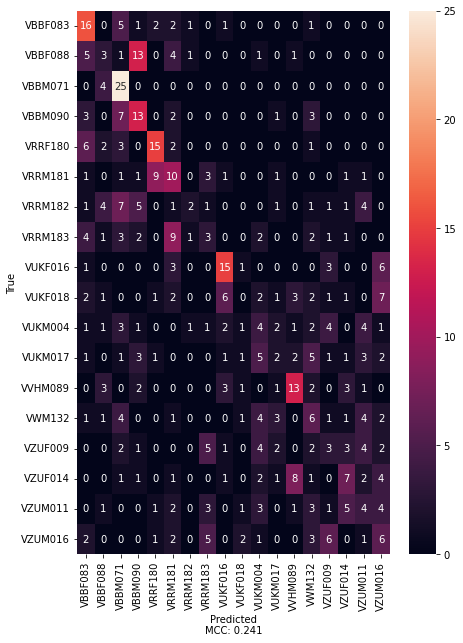

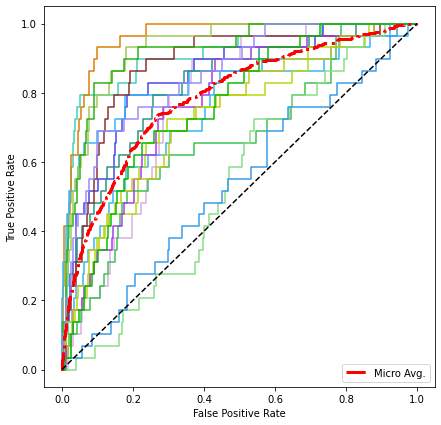

AUC score: 0.787


In [83]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y_tr)
pred_b, prob_b = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=ind_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=feature_extraction.one_hot(y_ts),
    y_score=prob_b, n_classes=len(ind_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

# Shift F1 ... FN

In [84]:
tr = pd.DataFrame(columns=training.columns)

for i in training.Code.unique():
    print("INDIVIDUAL: ", i)

    # temporary dataframe
    tmp_df = training.loc[training["Code"] == i].copy(deep=True)

    # indeces of selected individual
    idx = training.loc[training["Code"] == i].index

    tmp_df = augmenter.shift_formants(
        min_shift_Hz=25, max_shift_Hz=75,
        signals=sig_training[idx], sample_rates=sr_training[idx], metadata=tmp_df,
        directory="code/test/augmentation_techniques_test/test_audio", N=N
    )

    tr = tr.append(tmp_df, ignore_index=True)

tr.groupby(["Code"]).size()

INDIVIDUAL:  VBBF083
INDIVIDUAL:  VBBF088
INDIVIDUAL:  VBBM071
INDIVIDUAL:  VBBM090
INDIVIDUAL:  VRRF180
INDIVIDUAL:  VRRM181
INDIVIDUAL:  VRRM182
INDIVIDUAL:  VRRM183
INDIVIDUAL:  VUKF016
INDIVIDUAL:  VUKF018
INDIVIDUAL:  VUKM004
INDIVIDUAL:  VUKM017
INDIVIDUAL:  VVHM089
INDIVIDUAL:  VWM132
INDIVIDUAL:  VZUF009
INDIVIDUAL:  VZUF014
INDIVIDUAL:  VZUM011
INDIVIDUAL:  VZUM016


Code
VBBF083    214
VBBF088    214
VBBM071    214
VBBM090    214
VRRF180    214
VRRM181    214
VRRM182    214
VRRM183    214
VUKF016    214
VUKF018    214
VUKM004    214
VUKM017    214
VVHM089    214
VWM132     214
VZUF009    214
VZUF014    214
VZUM011    214
VZUM016    214
dtype: int64

## Extracting training coefficients

In [85]:
# extract MFCCs
sig_tr, sr_tr = feature_extraction.audio(tr.Path.to_list())
coefs, _ = feature_extraction.features(
    signals=sig_tr, sample_rates=sr_tr, n_subsamples=15, n_mels=40,
    n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs.shape

C:\Users\alessandro\Documents\UZH\Thesis\code\my_modules\feature_extraction.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(signals), np.array(sample_rates)


(3852, 15, 45)

In [86]:
# training targets
y_tr, _ = feature_extraction.get_targets(metadata_df=tr)

In [87]:
# flattening array
X = np.reshape(coefs, newshape=(coefs.shape[0], coefs.shape[1]*coefs.shape[2]))
X.shape

(3852, 675)

## Classification

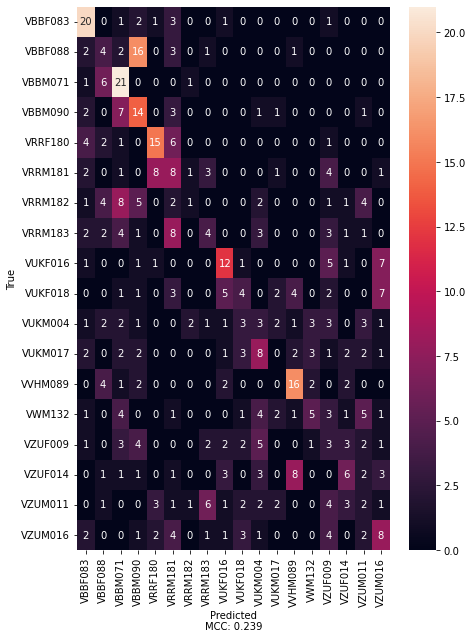

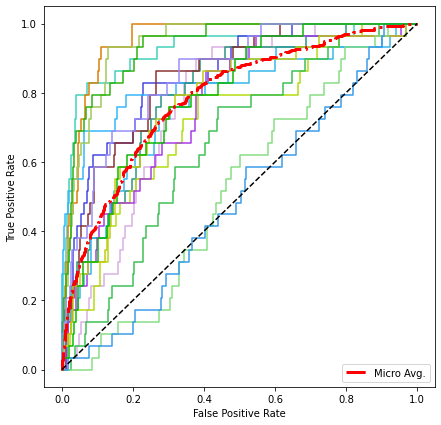

AUC score: 0.786


In [88]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y_tr)
pred_b, prob_b = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=ind_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=feature_extraction.one_hot(y_ts),
    y_score=prob_b, n_classes=len(ind_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))

# First Harmonic Distortion and then Augmentation

## Harmonic Distortion

In [12]:
training = augmenter.HarmDist(
    signals=sig_training, sample_rates=sr_training,
    metadata=training, directory="code/test/augmentation_techniques_test/test_audio"    
    )
testing = augmenter.HarmDist(
    signals=sig_ts, sample_rates=sr_ts,
    metadata=testing, directory="code/test/augmentation_techniques_test/test_audio"    
    )

In [13]:
testing.shape

(522, 13)

In [14]:
# new signals
sig_training, sr_training = feature_extraction.audio(training.Path.to_list())
sig_ts, sr_ts = feature_extraction.audio(testing.Path.to_list())

# testing targets
y_ts, ind_ts = feature_extraction.get_targets(metadata_df=testing)

In [15]:
# test coefficients
coefs_ts, _ = feature_extraction.features(
    signals=sig_ts, sample_rates=sr_ts, n_subsamples=15, n_mels=40,
    n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs_ts.shape
X_ts = np.reshape(coefs_ts, newshape=(coefs_ts.shape[0], coefs_ts.shape[1]*coefs_ts.shape[2]))
X_ts.shape

(522, 675)

## Augmentation (Shifting signal)

In [16]:
tr = pd.DataFrame(columns=training.columns)

for i in training.Code.unique():
    print("INDIVIDUAL: ", i)

    # temporary dataframe
    tmp_df = training.loc[training["Code"] == i].copy(deep=True)

    # indeces of selected individual
    idx = training.loc[training["Code"] == i].index

    tmp_df = augmenter.ShiftAugment(
        signals=sig_training[idx], sample_rates=sr_training[idx], metadata=tmp_df,
        directory="code/test/augmentation_techniques_test/test_audio", N=N
    )

    tr = tr.append(tmp_df, ignore_index=True)

tr.groupby(["Code"]).size()

INDIVIDUAL:  VBBF083
INDIVIDUAL:  VBBF088
INDIVIDUAL:  VBBM071
INDIVIDUAL:  VBBM090
INDIVIDUAL:  VRRF180
INDIVIDUAL:  VRRM181
INDIVIDUAL:  VRRM182
INDIVIDUAL:  VRRM183
INDIVIDUAL:  VUKF016
INDIVIDUAL:  VUKF018
INDIVIDUAL:  VUKM004
INDIVIDUAL:  VUKM017
INDIVIDUAL:  VVHM089
INDIVIDUAL:  VWM132
INDIVIDUAL:  VZUF009
INDIVIDUAL:  VZUF014
INDIVIDUAL:  VZUM011
INDIVIDUAL:  VZUM016


Code
VBBF083    214
VBBF088    214
VBBM071    214
VBBM090    214
VRRF180    214
VRRM181    214
VRRM182    214
VRRM183    214
VUKF016    214
VUKF018    214
VUKM004    214
VUKM017    214
VVHM089    214
VWM132     214
VZUF009    214
VZUF014    214
VZUM011    214
VZUM016    214
dtype: int64

## Extracting training coefficients

In [17]:
# extract MFCCs
sig_tr, sr_tr = feature_extraction.audio(tr.Path.to_list())
coefs, _ = feature_extraction.features(
    signals=sig_tr, sample_rates=sr_tr, n_subsamples=15, n_mels=40,
    n_mfcc=16, frame_stride=0.0001, fmin=100, fmax=5000
)
coefs.shape

(3852, 15, 45)

In [18]:
# training targets
y_tr, _ = feature_extraction.get_targets(metadata_df=tr)

In [19]:
# flattening array
X = np.reshape(coefs, newshape=(coefs.shape[0], coefs.shape[1]*coefs.shape[2]))
X.shape

(3852, 675)

## Classification

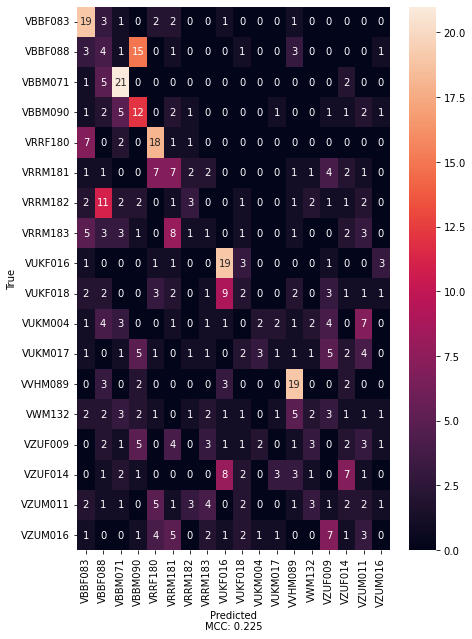

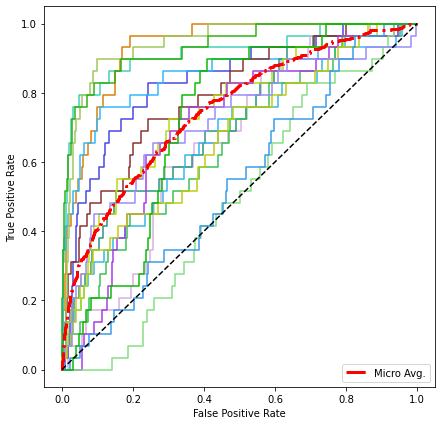

AUC score: 0.749


In [20]:
rf = algorithms.RandForest(random_state=42)
rf.fit(X=X, y=y_tr)
pred_b, prob_b = rf.predict(X=X_ts)

cf_rf, fig = evaluate_performance.conf_matrix(
    y=y_ts, yp=pred_b, labels=ind_ts,
    matthews_corr=evaluate_performance.matthews(y=y_ts, yp=pred_b)
)

auc_rf, fig = evaluate_performance.roc_auc(
    y=y_ts, y_true=feature_extraction.one_hot(y_ts),
    y_score=prob_b, n_classes=len(ind_ts)
)
print("AUC score: {:0.3f}".format(auc_rf))